In [6]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

import matplotlib.pyplot as plt


<h3> Model configuaration </h3>

In [2]:
device = 'cuda:3'
img_resolution = 256   # we have provided 128 and 256 pretrained models; you may train our model with your own preference, the training script is also provided.
T_step = 100  # number of steps for diffusion model [0,1000]

model_config = ffhq256_autoenc() if img_resolution == 256 else  ffhq128_autoenc()
model_config.T_eval = T_step

<h3> Model initialization </h3>

In [3]:
model = LitModel(model_config)
state = torch.load(f'checkpoints/{model_config.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device)

Global seed set to 0


Model params: 160.69 M


BeatGANsAutoencModel(
  (time_embed): TimeStyleSeperateEmbed(
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (style): Identity()
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (cond_emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)

<h3> Classifer initialization </h3>
We'll use a trained classifer to provide a class direction in our image manipulation process

In [4]:
classifer_config = ffhq256_autoenc_cls() if img_resolution == 256 else ffhq128_autoenc_cls()
classifier = ClsModel(classifer_config)
state = torch.load(f'checkpoints/{classifer_config.name}/last.ckpt', map_location='cpu')
print('latent step:', state['global_step'])
classifier.load_state_dict(state['state_dict'], strict=False)
classifier.to(device)

Global seed set to 0


loading pretrain ... 130M
step: 1563562
_IncompatibleKeys(missing_keys=[], unexpected_keys=['x_T'])
loading latent stats ...
latent step: 9375


ClsModel(
  (model): BeatGANsAutoencModel(
    (time_embed): TimeStyleSeperateEmbed(
      (time_embed): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): SiLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
      )
      (style): Identity()
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (h_upd): Identity()
          (x_upd): Identity()
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=512, out_features=256, bias=True)
          )
          (cond_emb_layers): Sequential(
            (0):

Data initialization

In [32]:
def convert2rgb(img,adjust_scale=True):
    convert_img = torch.tensor(img)
    if adjust_scale: convert_img = (convert_img+1)/2
    return (convert_img).permute(1, 2, 0).cpu()

<h3> Custom dataset </h3>
In addition, you may feed any well-aligned portrait face image into our model. The alignment and image preparation script is also provided; check out align.py

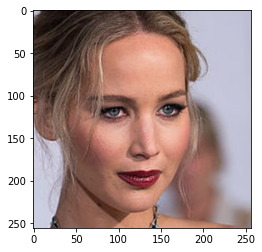

In [15]:
imgdataset_path = 'imgs_align'  # path to your own image dataset 
data = ImageDataset(imgdataset_path, image_size=model_config.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
plt.imshow(convert2rgb(data[0]['img']))

In [24]:
batch = data[0]['img'][None]

semantic_latent = model.encode(batch.to(device))
stochastic_latent = model.encode_stochastic(batch.to(device), semantic_latent)

<h3> Manipulation </h3>

In [17]:
CelebAttrDataset.id_to_cls

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

In [34]:
target_class = 'Eyeglasses'  
manipulation_amp = 0.2

cls_id = CelebAttrDataset.cls_to_id[target_class]
class_direction = classifier.classifier.weight[cls_id]
normalized_class_direction = F.normalize(class_direction[None, :], dim=1)

normalized_semantic_latent = classifier.normalize(semantic_latent)
normalized_manipulation_amp = manipulation_amp * math.sqrt(512)
normalized_manipulated_semantic_latent =  normalized_semantic_latent + normalized_manipulation_amp*normalized_class_direction

manipulated_semantic_latent = classifier.denormalize(normalized_manipulated_semantic_latent)

/home/nessessence/anaconda3/envs/auto_ddpm/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


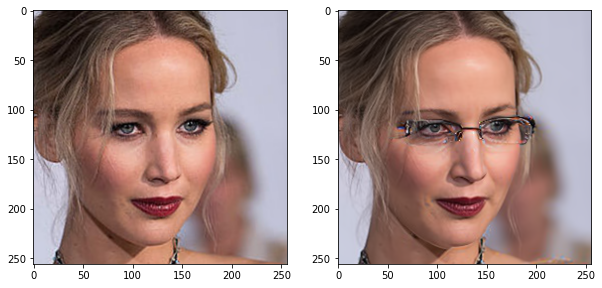

In [33]:
manipulated_img = model.render(stochastic_latent, manipulated_semantic_latent)[0]
original_img = data[0]['img']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(convert2rgb(original_img))
ax[1].imshow(convert2rgb(manipulated_img,adjust_scale=False))
# plt.savefig('imgs_manipulated/compare.png')